<a href="https://colab.research.google.com/github/zhaorui-bi/awesome-MaSIF/blob/main/dmasif_site_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dMaSIF NPI site
This is an implementation of dMaSIF framework to identify potential nucleic acids binding sites (https://github.com/geraseva/masif_npi).

For more details, check out the following papers:

1) [Gainza, P., Sverrisson, F., Monti, F., Rodola, E., Boscaini, D., Bronstein, M. M., & Correia, B. E. (2020). Deciphering interaction fingerprints from protein molecular surfaces using geometric deep learning. Nature Methods, 17(2), 184-192.](https://doi.org/10.1038/s41592-019-0666-6)

2) [Sverrisson, F., Feydy, J., Correia, B. E., & Bronstein, M. M. (2021). Fast end-to-end learning on protein surfaces. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 15272-15281).](http://dx.doi.org/10.1109/CVPR46437.2021.01502)

3) [Geraseva, E., & Golovin, A. (2023). Nucleic Acid-Protein Interaction Prediction Using Geometric Deep Learning. In Russian Supercomputing Days (pp. 239-251). Cham: Springer Nature Switzerland.](https://doi.org/10.1007/978-3-031-49435-2_17)



In [1]:
#@title Install dependencies

print('Downloading dMaSIF..')
%cd -q /content
!rm -fr masif_npi > /dev/null
!git clone --quiet https://github.com/geraseva/masif_npi > /dev/null

import sys
sys.path.append('masif_npi')

print('Installing PyKeops..')
!pip install pykeops &> /dev/null
print('Installing BioPython..')
!pip install biopython &> /dev/null
print('Installing py3Dmol..')
!pip install py3Dmol &> /dev/null
print('Installing reduce..')
!git clone --quiet https://github.com/rlabduke/reduce > /dev/null
!cmake reduce &> /dev/null
!make &> /dev/null
!sudo make install &> /dev/null


Installing PyKeops..
Installing BioPython..
Installing py3Dmol..
Installing reduce..


In [2]:
#@title Upload a pdb file
#@markdown Write down PDB ID to download a file from Protein Data Bank.

#@markdown Or upload a custom pdb file.
from google.colab import files
import os

# Create folder for the pdbs
pred_dir = '/content/pdbs'
isExist = os.path.exists(pred_dir)
if not isExist:
  os.makedirs(pred_dir)

pdb_file = "6whm" # @param [ "custom"] {allow-input: true}

if pdb_file=="custom":
    uploaded = files.upload()
    pdb_file=list(uploaded.keys())[0]
    with open(f'/content/pdbs/{pdb_file}',"wb") as out:
        out.write(uploaded[pdb_file])
    os.remove(pdb_file)
    pdb_file=f'/content/pdbs/{pdb_file}'
else:
    os.system(f"wget -qnc -O /content/pdbs/{pdb_file}.pdb https://files.rcsb.org/view/{pdb_file}.pdb ")
    pdb_file=f'/content/pdbs/{pdb_file}.pdb'

#@markdown Select chains of interest. Or leave the line blank to select all chains.

chain_names = 'A' #@param {type:"string"}
chain_name=chain_names.replace(' ','').replace(',','').strip()

#@markdown Structure must be protonated. If it is already protonated, turn off the flag.

protonate = True # @param {type:"boolean"}
if protonate:
    from data import protonate
    protonate(pdb_file,pdb_file)
    print('Protonated')

from Bio.PDB import *
from data import find_modified_residues, load_structure_np

parser = PDBParser(QUIET=True)
structure = parser.get_structure('sample', pdb_file)

if chain_name=='':
    for ch in structure[0]:
        chain_name+=ch.get_id()

modified=find_modified_residues(pdb_file)

p=load_structure_np(structure, chain_ids=chain_name, modified=modified)
print('Loaded',p['atom_xyz'].shape[0],'atoms')


[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
Protonated
Loaded 2790 atoms


In [5]:
#@title Run model

import torch
from model import dMaSIF
from data import find_modified_residues, load_structure_np, encode_npy

#@markdown Select which binding to predict.

binding ='protein' # @param ["DNA", "RNA", "NA", "protein"]

if binding=='DNA':
    model_path = "masif_npi/models/dna_site_b2"
elif binding=='RNA':
    model_path = "masif_npi/models/rna_site_b2"
elif binding=='NA':
    model_path = "masif_npi/models/npi_site_b2"
elif binding=='protein':
    model_path = "masif_npi/models/prot_site_b2"

encoders={'atom_types': [{'name': 'atom_types',
                             'encoder': {'C':0,'H':1,'O': 2,'N':3,'-':4}},
                            {'name': 'atom_rad',
                             'encoder': {'H':110,'C': 170,'N':155,'O':152,'-':180}}]}

device='cuda' if torch.cuda.is_available() else 'cpu'
print('Device:',device)

checkpoint=torch.load(model_path, map_location=device, weights_only=False)
if checkpoint['net_args'].get('encoders')!=None and len(checkpoint['net_args']['encoders'])>0:
    encoders=checkpoint['net_args']['encoders']
else:
    checkpoint['net_args']['encoders']=encoders

net = dMaSIF(checkpoint['net_args'])
net = net.to(device)
net.load_state_dict(checkpoint["model_state_dict"])
net.eval()
torch.set_grad_enabled(False)

print('# Model loaded')
print('## Model arguments:',checkpoint['net_args'])

P1 = encode_npy(p, encoders=encoders)
print('# Start prediction')
outputs = net(P1, None)
print('# Done')

coords=outputs['P1']['xyz'].cpu().detach().numpy().astype(np.float64)
preds=outputs['P1']['preds'].sigmoid().cpu().detach().numpy().astype(np.float64)

print('Generated',preds.shape[0],'points')


Device: cuda
# Model loaded
## Model arguments: {'feature_generation': 'AtomNet_V_MP', 'resolution': 1.0, 'distance': 1.05, 'variance': 0.1, 'sup_sampling': 20, 'atom_dims': 5, 'chem_dims': 6, 'curvature_scales': [1.0, 2.0, 3.0, 5.0, 10.0], 'emb_dims': 8, 'orientation_units': 14, 'post_units': 8, 'n_outputs': 1, 'n_layers': 3, 'radius': 9.0, 'split': False, 'dropout': 0.0, 'encoders': {'atom_types': [{'name': 'atom_types', 'encoder': {'C': 0, 'H': 1, 'O': 2, 'N': 3, '-': 4}}, {'name': 'atom_rad', 'encoder': {'H': 110, 'C': 170, 'N': 155, 'O': 152, '-': 180}}]}, 'knn': 16}
# Start prediction


/content/masif_npi/data.py:153: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  protein_data['atom_xyz']=tensor(p['atom_xyz'])


[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Exp(-Sqrt(Sum((a-b)**2))) with a=Var(0,3,0), b=Var(1,3,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (a*Exp(-Sqrt(Sum((b-c)**2))))/d with a=Var(0,1,0), b=Var(1,3,0), c=Var(2,3,1), d=Var(3,1,1) ... OK
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 1) of formula [-Sqrt(Sum((a-b)**2))/c,1] with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,1,0) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (((a-b)*(Extract(d,1,1)/c))*Rsqrt(Sum((a-b)**2)))*Exp(-Sqrt(Sum((a-b)**2))/c-Extract(e,0,1)) with a=Var(0,3,0), b=Var(1,3,1), c=Var(2,1,0), d=Var(3,2,1), e=Var(4,2,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula (((b-c)*((e/d)*a))*Rsqrt(Sum((b-c)**2)))*Exp(-Sqrt(Sum((b-c)**2))) with a=Var(0,1,0), b=Var(1,3,0), c=Var(2,3,1), d=Var(3,1,1), e=Var(4,1,1) ... OK
[

In [6]:
#@title Download predictions

pred_dir = '/content/preds'
isExist = os.path.exists(pred_dir)
if not isExist:
    os.makedirs(pred_dir)

out_file=f'{pred_dir}/{pdb_file.split("/")[-1].split(".")[0]}_{chain_name}_{binding}_binding.npz'
np.savez(out_file, coords=coords, preds=preds)
print('Saved to' ,out_file)
files.download(out_file)

#@markdown The file can be loaded using commands like:

#@markdown ```data=np.load(out_file)```

#@markdown ```coords = data["coords"]```

#@markdown ```preds = data["preds"]```


Saved to /content/preds/6whm_A_protein_binding.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#@title Get hotspot residues

dist=((coords[:,None,:]-p['atom_xyz'])**2).sum(-1)
nearest_atoms=dist.argmin(1)
hotspot_res = {}
for id in np.unique(nearest_atoms):
    hotspot_res[f"{p['atom_chains'][id]} {p['atom_resids'][id]} {p['atom_resnames'][id]}"]=preds[nearest_atoms==id].max()

#@markdown Select top_n hotspot residues to display
top_n=20 # @param
#@markdown Or select interaction probability threshold
thr=0.5 # @param

print('Sorted on residue contribution (high to low)')
for i, w in enumerate(sorted(hotspot_res, key=hotspot_res.get, reverse=True)):
    if i>=top_n:
        break
    if hotspot_res[w]<thr:
        break
    print(w, hotspot_res[w])

Sorted on residue contribution (high to low)
A 82 ARG 0.8874114155769348
A 78 ILE 0.8840904235839844
A 12 MET 0.8692455291748047
A 46 PHE 0.862908661365509
A 81 GLY 0.8491567969322205
A 49 SER 0.8463661074638367
A 77 GLU 0.8457949757575989
A 74 HIS 0.8336672782897949
A 16 LEU 0.8331262469291687
A 19 LYS 0.8313882946968079
A 10 ASN 0.8206632733345032
A 86 MET 0.8093957304954529
A 112 TYR 0.800062358379364
A 73 LYS 0.7995741963386536
A 50 ASP 0.7945688962936401
A 24 TYR 0.7940136194229126
A 170 ARG 0.7895612120628357
A 15 GLU 0.781347393989563
A 83 ASP 0.7701749205589294
A 134 LYS 0.7674084901809692


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

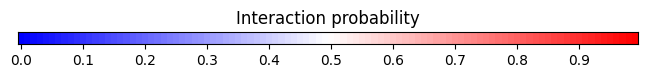

In [8]:
#@title Visualize output

import py3Dmol
import matplotlib.pyplot as plt
import matplotlib as mpl

#@markdown Choose any colormap available from matplotlib
colormap='bwr' # @param [ 'jet', 'coolwarm', 'bwr','rainbow'] {allow-input: true}
cmap = plt.get_cmap(colormap)

v = py3Dmol.view(width=800,height=500)

#@markdown Choose whether to show surface dots
show_dots=True # @param {type:"boolean"}

if show_dots:
    dot_colors=[mpl.colors.to_hex(rgb) for rgb in cmap(preds)[:,0,:]]
    for i in range(outputs['P1']['xyz'].shape[0]):
        v.addSphere({"center": dict(zip(["x","y","z"], coords[i])),
                     "color": dot_colors[i],
                     "radius": 0.2,
    })

#@markdown Choose whether to show target chains
show_target_chains=True # @param {type:"boolean"}
#@markdown Choose target chains style
layout_target_chains='line' # @param [ 'cartoon', 'stick', 'line', 'sphere']
color_target_chains='colormap' # @param [ 'colormap','green', 'blue', 'red','yellow', 'gray',  'black'] {allow-input: true}

#@markdown Choose whether to show other chains
show_other_chains=True # @param {type:"boolean"}
#@markdown Choose other chains style
layout_other_chains='stick' # @param [ 'cartoon', 'stick', 'line', 'sphere']
color_other_chains='green' # @param [ 'green', 'blue', 'red','yellow', 'gray', 'black'] {allow-input: true}

v.addModel(open(pdb_file,'r').read(),'pdb')
if show_other_chains:
    v.setStyle({layout_other_chains: {'color': color_other_chains},
                'opacity': 0.8})
else:
    v.setStyle({'outline':{}})

if show_target_chains:
    if color_target_chains=='colormap':
        resi_colors=[(key.split(' '),mpl.colors.to_hex(cmap(hotspot_res[key]))) for key in hotspot_res.keys()]

        v.setStyle({'chain':[*chain_name]},
                   {layout_target_chains:{'color': mpl.colors.to_hex(cmap(0))}})
        for resi, color in resi_colors:
            v.setStyle({'chain': resi[0], 'resi': resi[1]},
                       {layout_target_chains:{'color':color}})
    else:
        v.setStyle({'chain':[*chain_name]},
                   {layout_target_chains:{'color': color_target_chains}})
else:
    v.setStyle({'chain':[*chain_name]},
               {'outline':{}})

v.zoomTo()
v.show()
plt.figure(figsize=(8,2))
plt.title('Interaction probability')
plt.imshow(np.tile(np.arange(0,1,.01),(2,1)), cmap=cmap)
plt.yticks(np.arange(0))
plt.xticks(np.arange(0,100,10), np.arange(0,1,.1).round(1))
plt.show()